In [ ]:
from Piece import Piece
from Board import Board

In [21]:
def brute_force_solve(current_board):
    
    if current_board in solutions:
        return solutions[current_board]
    
    result = set()
    
    counter = current_board.countAvailablePieces()
    remaining = [item for item in counter.keys() if counter[item]>0]
    if len(remaining) == 0 and not current_board.containsNull():
        result.add( current_board )
        
    actions = current_board.getActions()
    
    for piece, i, j in actions:
        next_board = current_board.placePiece(piece, i, j)
        solution = brute_force_solve(next_board)
        result.update(solution)
                    
    solutions[current_board] = result
    return result
    

In [45]:
b = Board.createBoard(rows=4, columns=4, curves=6,tees=6,straight=2,cross=2)
b = b.placePiece(Piece.CURVE_DOWN_RIGHT, 0,0)
b = b.placePiece(Piece.CURVE_DOWN_LEFT, 0,3)
b = b.placePiece(Piece.CURVE_UP_RIGHT, 3,0)
b = b.placePiece(Piece.CURVE_UP_LEFT, 3,3)
b = b.placePiece(Piece.TEE_DOWN, 0,1)
b = b.placePiece(Piece.CROSS, 1,1)

solutions = dict()
solution = brute_force_solve(b)
print(len(solution))

20


In [46]:
for board in solution:
    print(board.printBoard())


╭┬┬╮
╰┼┤│
╭┼┤│
╰┴┴╯
╭┬┬╮
├┼┼┤
├╯╰┤
╰──╯
╭┬┬╮
╰┼┴┤
╭┼─┤
╰┴─╯
╭┬─╮
├┼─┤
├┼┬┤
╰╯╰╯
╭┬┬╮
╰┼┼┤
╭┴┴┤
╰──╯
╭┬─╮
╰┼┬┤
╭┼┴┤
╰┴─╯
╭┬─╮
├┼┬╯
├┴┼╮
╰─┴╯
╭┬┬╮
╰┼┤│
╭┼┴┤
╰┴─╯
╭┬┬╮
├┼┼╯
├┴┴╮
╰──╯
╭┬─╮
├┼┬┤
│├┼┤
╰╯╰╯
╭┬┬╮
├┼┤│
│├┼┤
╰╯╰╯
╭┬─╮
├┼┬╯
├┼┴╮
╰┴─╯
╭┬─╮
├┼┬╯
│├┼╮
╰┴┴╯
╭┬┬╮
├┼┼╯
││├╮
╰┴┴╯
╭┬┬╮
├┼┼┤
││├┤
╰╯╰╯
╭┬┬╮
├┼┼╯
│├┴╮
╰┴─╯
╭┬─╮
├┼┬┤
├┼┤│
╰╯╰╯
╭┬─╮
╰┼─┤
╭┼┬┤
╰┴┴╯
╭┬─╮
╰┼┬┤
╭┼┤│
╰┴┴╯
╭┬─╮
├┼─╯
├┼┬╮
╰┴┴╯


### Q-learning

In [1]:
%matplotlib inline
import random
import numpy as np
import pandas as pd
import random

from Piece import Piece
from Board import Board

In [2]:
def board_reward(board):
    
    if board.containsNull() or board.getScore()>0:
    # no solution, the board has empty cells
        return -1
    

    return 1

In [3]:
def getActionQvalues(board, actions):
    result = dict()
    
    if qvalues.get(board) == None:
        qvalues[board] = dict()
    
    for action in actions:
        if qvalues[board].get(action) == None:
            qvalues[board][action] = (0,0)
        
        result[action] = qvalues[board][action]
        
    return result

In [4]:
def update_qvalues(board, action, reward):
    k, q = qvalues[board][action]   
    alpha = 0.001
    newq = reward*alpha + (1-alpha) * q
    qvalues[board][action] = k+1, newq
    

In [5]:
def pick_next_action(board, method, epsilon=0.0, tau=1):
    
    actions = board.getActions()
    if len(actions)==0:
        return None

    qvector = getActionQvalues(board, actions)
    
    if method == 'RANDOM':
        next_action = random.choice(actions)
    elif method == 'EPSILON':
        if random.random() > epsilon:
            max_reward = np.max([q for (k,q) in qvector.values()])
            actions = [action for action in qvector if qvector[action][1] == max_reward]
        next_action = random.choice(actions)
    elif method == 'SOFTMAX':
        k = list(qvector.keys())
        v = np.array([q/tau for (k,q) in qvector.values()])
        v -= np.max(v)
        p = np.exp(v) / np.sum(np.exp(v))
        rid = np.random.choice(range(len(k)), p=p)
        next_action = k[rid]
    
    return next_action

In [31]:
def qsolve(current_board):
    gamma = 1.0

    action = pick_next_action(current_board, 'SOFTMAX', tau=0.1)
    if action==None:
        return board_reward(current_board)

    next_board = current_board.placePiece(*action)
    
    # We keep the boards to have at most 2 exits
    #if next_board.getScore()>0:
    #    reward = board_reward(next_board)
    #else:
    reward = 1 + gamma * qsolve(next_board)
        
    update_qvalues(current_board, action, reward)
    
    return reward
     

In [37]:
qvalues = dict() # itialize the q-values array
perf = [] # initializing the list
b = Board.createBoard(rows=4, columns=4, curves=6,tees=6,straight=2,cross=2)
b = b.placePiece(Piece.CURVE_DOWN_RIGHT, 0,0)
b = b.placePiece(Piece.CURVE_DOWN_LEFT, 0,3)
b = b.placePiece(Piece.CURVE_UP_RIGHT, 3,0)
b = b.placePiece(Piece.CURVE_UP_LEFT, 3,3)
b = b.placePiece(Piece.CROSS, 1,1)
b = b.placePiece(Piece.TEE_DOWN, 0,1)
avg = qsolve(b) # EWM of the award
print(b.printBoard())

╭┬.╮
.┼..
....
╰..╯


1000,  7.664
2000,  8.559


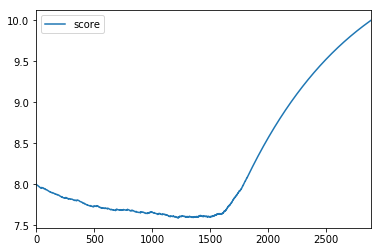

In [38]:
episodes = 100000
alpha = 0.001
tau = 1 # start exploiting
for _ in range(episodes):
    
    new_v = qsolve(b)
    
    avg = alpha * new_v + (1-alpha) * avg
    perf.append( avg )
    
    if len(perf)%1000==0:
        print( "{i}, {s:6.3f}".format(i=len(perf), s=avg) )
        
        
    if avg >10: 
        pd.DataFrame(perf, columns=["score"]).plot()
        break
    


In [39]:
def printsolve(current_board):
    
    # print(current_board.printBoard())
    
    gamma = 1.0

    action = pick_next_action(current_board, 'SOFTMAX', tau=2)
    
    if action==None:
        return current_board, board_reward(current_board)
    
    # print(action, "==>", qvalues[current_board][action])

    next_board = current_board.placePiece(*action)
    if next_board.getScore()>0:
        return next_board, board_reward(next_board)
    
    b,r = printsolve(next_board)
    reward = 1 + gamma * r
    
    update_qvalues(current_board, action, reward)
    
    return b, reward



In [42]:
b = Board.createBoard(rows=4, columns=4, curves=6,tees=6,straight=2,cross=2)
b = b.placePiece(Piece.CURVE_DOWN_RIGHT, 0,0)
b = b.placePiece(Piece.CURVE_DOWN_LEFT, 0,3)
b = b.placePiece(Piece.CURVE_UP_RIGHT, 3,0)
b = b.placePiece(Piece.CURVE_UP_LEFT, 3,3)
b = b.placePiece(Piece.TEE_DOWN, 0,1)
b = b.placePiece(Piece.CROSS, 1,1)

#boards = set()
i=0
while i<2000:
    i += 1
    f, r = printsolve(b)
    if r==11 and f not in boards:
        print(f.printBoard()+"\n")
        boards.add(f)
        i=0

╭┬┬╮
├┼┤│
│├┼┤
╰╯╰╯

╭┬┬╮
├┼┼╯
├┴┴╮
╰──╯

╭┬─╮
├┼┬┤
│├┼┤
╰╯╰╯



In [43]:
len(boards)

20

In [51]:
for board in boards:
    #if board.getScore()==0:
    print(board.printBoard())
    print(board.rotate().printBoard())
    print(board.rotate().rotate().printBoard())
    print(board.rotate().rotate().rotate().printBoard())
    print('------------------')

╭┬┬╮
╰┼┤│
╭┼┤│
╰┴┴╯
╭╮╭╮
├┼┼┤
├┴┴┤
╰──╯
╭┬┬╮
│├┼╯
│├┼╮
╰┴┴╯
╭──╮
├┬┬┤
├┼┼┤
╰╯╰╯
------------------
╭┬┬╮
├┼┤│
│├┼┤
╰╯╰╯
╭─┬╮
╰┬┼┤
╭┼┴┤
╰┴─╯
╭╮╭╮
├┼┤│
│├┼┤
╰┴┴╯
╭─┬╮
├┬┼╯
├┼┴╮
╰┴─╯
------------------
╭┬┬╮
├┼╯│
├┼╮│
╰┴┴╯
╭┬┬╮
├┼┼┤
├╯╰┤
╰──╯
╭┬┬╮
│╰┼┤
│╭┼┤
╰┴┴╯
╭──╮
├╮╭┤
├┼┼┤
╰┴┴╯
------------------
╭┬┬╮
├┼┼╯
├┴┴╮
╰──╯
╭┬┬╮
│├┼┤
│├┼┤
╰╯╰╯
╭──╮
╰┬┬┤
╭┼┼┤
╰┴┴╯
╭╮╭╮
├┼┤│
├┼┤│
╰┴┴╯
------------------
╭┬┬╮
╰┼┴┤
╭┼─┤
╰┴─╯
╭╮╭╮
├┼┼┤
││├┤
╰┴┴╯
╭─┬╮
├─┼╯
├┬┼╮
╰┴┴╯
╭┬┬╮
├┤││
├┼┼┤
╰╯╰╯
------------------
╭┬─╮
├┼┬╯
├┼┴╮
╰┴─╯
╭┬┬╮
├┼┼┤
│├┤│
╰╯╰╯
╭─┬╮
╰┬┼┤
╭┴┼┤
╰─┴╯
╭╮╭╮
│├┤│
├┼┼┤
╰┴┴╯
------------------
╭┬┬╮
╰┼┼┤
╭┤││
╰┴┴╯
╭╮╭╮
├┴┼┤
├─┼┤
╰─┴╯
╭┬┬╮
││├╯
├┼┼╮
╰┴┴╯
╭┬─╮
├┼─┤
├┼┬┤
╰╯╰╯
------------------
╭┬┬╮
├┼┤│
├┼┤│
╰╯╰╯
╭┬┬╮
╰┼┼┤
╭┴┴┤
╰──╯
╭╮╭╮
│├┼┤
│├┼┤
╰┴┴╯
╭──╮
├┬┬╯
├┼┼╮
╰┴┴╯
------------------
╭┬─╮
╰┼┬┤
╭┼┴┤
╰┴─╯
╭╮╭╮
├┼┼┤
│├┤│
╰┴┴╯
╭─┬╮
├┬┼╯
├┴┼╮
╰─┴╯
╭┬┬╮
│├┤│
├┼┼┤
╰╯╰╯
------------------
╭┬┬╮
╰┼┤│
╭┴┼┤
╰─┴╯
╭╮╭╮
│├┼┤
├┼┴┤
╰┴─╯
╭┬─╮
├┼┬╯
│├┼╮
╰┴┴╯
╭─┬╮
├┬┼┤
├┼┤│
╰╯╰╯
------------------
╭┬┬╮
├┼┼╯
